#**자살충동 예측 모델연구 **





전체 연구 순서
1. 연구 목적 및 연구질문설정
2. 데이터 구조 이해(EDA)
3. 데이터 전처리 (encoding, 결측치, feature selection)
4. 모델링 (Logistic + XGBsoost+Ensemble)
5. 모델평가 (AUC, F1, Recall)
6. SHAP 해석
7. 고위험군 도출 및 프로파일링
8. 결과 및 시사점
9. 결론

## 1. 연구 목적 및 연구질문 설정
- 연구목적
개인의 특성(성별, 나이), 생활습관(수면, 식습관), 심리. 환경적 요인(직무만족도, 학업성취도, 가족력 등)에 기반하여 자살충돌 발생 가능성을 예측하는 모델 구축

2. 연구질문
- 어떤 요인이 자살 충동 위험에 가장 큰 영향을 미치는가
- 변수간 상호 작용은 위험에 어떤 변화를 주는가
- 머신러닝(XGBoost, 로지스틱 회귀 등 ) 모델 중 어떤 것이 예측력이 높은가
- 예측 결과를 활용하여 고위험군 특성을 어떻게 도출할수 있는가


# 2.  데이터 구조 이해



In [ ]:
import pandas as pd

train = pd.read_csv("train.csv")


In [ ]:
train.head()


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   



> 인도의 학생 자살충동이 직장인의 1.5배 더 높은것으로 확인됨



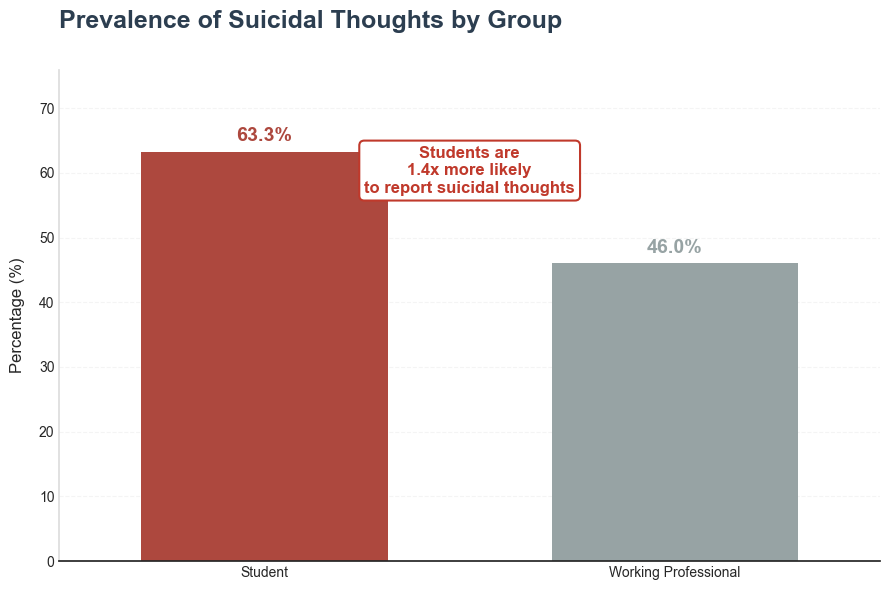

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dependencies moved from previous cells to resolve NameError
train = pd.read_csv("train.csv")
df_student = train[train["Working Professional or Student"] == "Student"].copy()
df_worker  = train[train["Working Professional or Student"] == "Working Professional"].copy()

# 1. 데이터 준비 (비율 계산)

target_col = "Have you ever had suicidal thoughts ?"
student_risk = df_student[target_col].value_counts(normalize=True).get('Yes', 0) * 100
worker_risk = df_worker[target_col].value_counts(normalize=True).get('Yes', 0) * 100

risk_data = pd.DataFrame({
    'Group': ['Student', 'Working Professional'],
    'Suicidal_Risk': [student_risk, worker_risk]
})

# 2. 스타일 설정 (Clean & Professional)
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(9, 6))

# 3. 막대 그래프 그리기 (Warning 해결: hue 추가, dodge=False)
colors = ['#C0392B', '#95A5A6'] # Deep Red (Danger) vs Grey (Reference)
# x='Group'을 hue에도 할당하여 경고를 없앱니다.
bars = sns.barplot(x='Group', y='Suicidal_Risk', data=risk_data,
                   hue='Group', palette=colors, ax=ax, width=0.6, dodge=False)

# Legend가 자동으로 생기면 제거 (깔끔하게)
if ax.get_legend() is not None:
    ax.get_legend().remove()

# 4. 디자인 디테일
ax.set_title('Prevalence of Suicidal Thoughts by Group',
             fontsize=18, fontweight='bold', pad=30, loc='left', color='#2C3E50')
ax.set_ylabel('Percentage (%)', fontsize=12, labelpad=10)
ax.set_xlabel('')
ax.set_ylim(0, max(student_risk, worker_risk) * 1.2) # 상단 여유 공간

# 테두리 정리 (Minimalism)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='#DDDDDD')

# 5. 수치 표시 (막대 색상과 깔맞춤)
for i, p in enumerate(bars.patches):
    height = p.get_height()
    if pd.isna(height) or height == 0: continue

    # 막대 색상 가져오기
    bar_color = p.get_facecolor()

    ax.text(p.get_x() + p.get_width() / 2., height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold', color=bar_color)

# 6. 격차(Gap) 강조 메시지
gap_ratio = student_risk / worker_risk
props = dict(boxstyle='round', facecolor='white', alpha=1, edgecolor='#C0392B', linewidth=1.5)
ax.text(0.5, max(student_risk, worker_risk) * 0.9,
        f"Students are\n{gap_ratio:.1f}x more likely\nto report suicidal thoughts",
        fontsize=12, color='#C0392B', fontweight='bold', ha='center', bbox=props)

plt.tight_layout()
plt.show()

> Group Splitting(학생/직장인 나누기)

In [ ]:
df_student = train[train["Working Professional or Student"] == "Student"].copy()
df_worker  = train[train["Working Professional or Student"] == "Working Professional"].copy()

df_student.shape, df_worker.shape


((27901, 20), (112799, 20))

In [ ]:
df_student.info()
df_student['Gender'].value_counts(dropna=False)
df_student['Sleep Duration'].value_counts(dropna=False)
df_student["Degree"].value_counts(dropna=False)
df_student["Have you ever had suicidal thoughts ?"].value_counts(dropna=False)

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 2 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Name                                   27901 non-null  object 
 2   Gender                                 27901 non-null  object 
 3   Age                                    27901 non-null  float64
 4   City                                   27901 non-null  object 
 5   Working Professional or Student        27901 non-null  object 
 6   Profession                             34 non-null     object 
 7   Academic Pressure                      27892 non-null  float64
 8   Work Pressure                          3 non-null      float64
 9   CGPA                                   27892 non-null  float64
 10  Study Satisfaction                     27891 non-null  float64
 11  Job Sa

Have you ever had suicidal thoughts ?
Yes    17656
No     10245
Name: count, dtype: int64

Feature Selection

In [ ]:
student_features = [
    "Gender",
    "Sleep Duration",
    "Dietary Habits",
    "Degree",
    "Family History of Mental Illness",
    "Age",
    "Academic Pressure",
    "CGPA",
    "Study Satisfaction",
    "Work/Study Hours",
    "Financial Stress",
]

df_student_model = df_student[student_features + ["Have you ever had suicidal thoughts ?"]].copy()


# 2. 직장인 그룹


📌 자살위험 증가 요인 (강 → 약)

중년층에서의 연령 증가 (U자 형태 위험도)

높은 재정 스트레스 (Financial Stress)

높은 업무 스트레스 (Work Pressure)

낮은 직무 만족도

장시간 근로

불건강한 식습관

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
5,5,Vani,Female,59.0,Ahmedabad,Working Professional,Finanancial Analyst,NaN,2.0,NaN,NaN,5.0,5-6 hours,Healthy,MCA,No,7.0,5.0,No,0


,AUC,Accuracy
0,0.584961,0.580629


,Pred 0,Pred 1
Actual 0,10528,1651
Actual 1,7810,2571


,precision,recall,f1-score,support
0,0.574108,0.864439,0.689976,12179.000000
1,0.608953,0.247664,0.352119,10381.000000
accuracy,0.580629,0.580629,0.580629,0.580629
macro avg,0.591531,0.556051,0.521048,22560.000000
weighted avg,0.590142,0.580629,0.534511,22560.000000


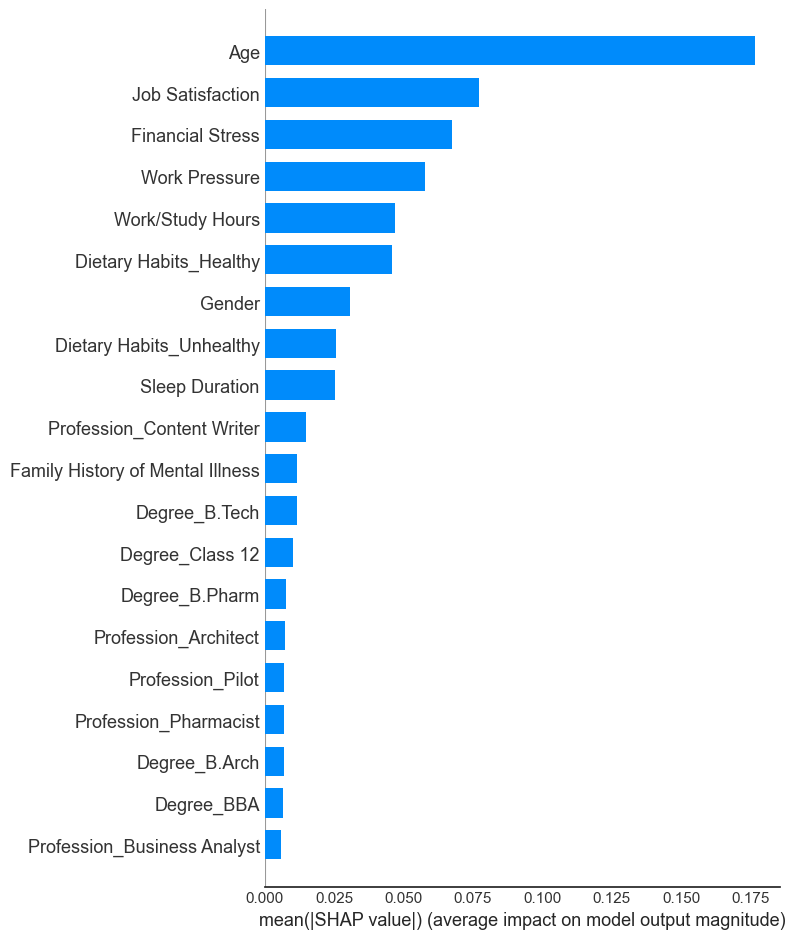

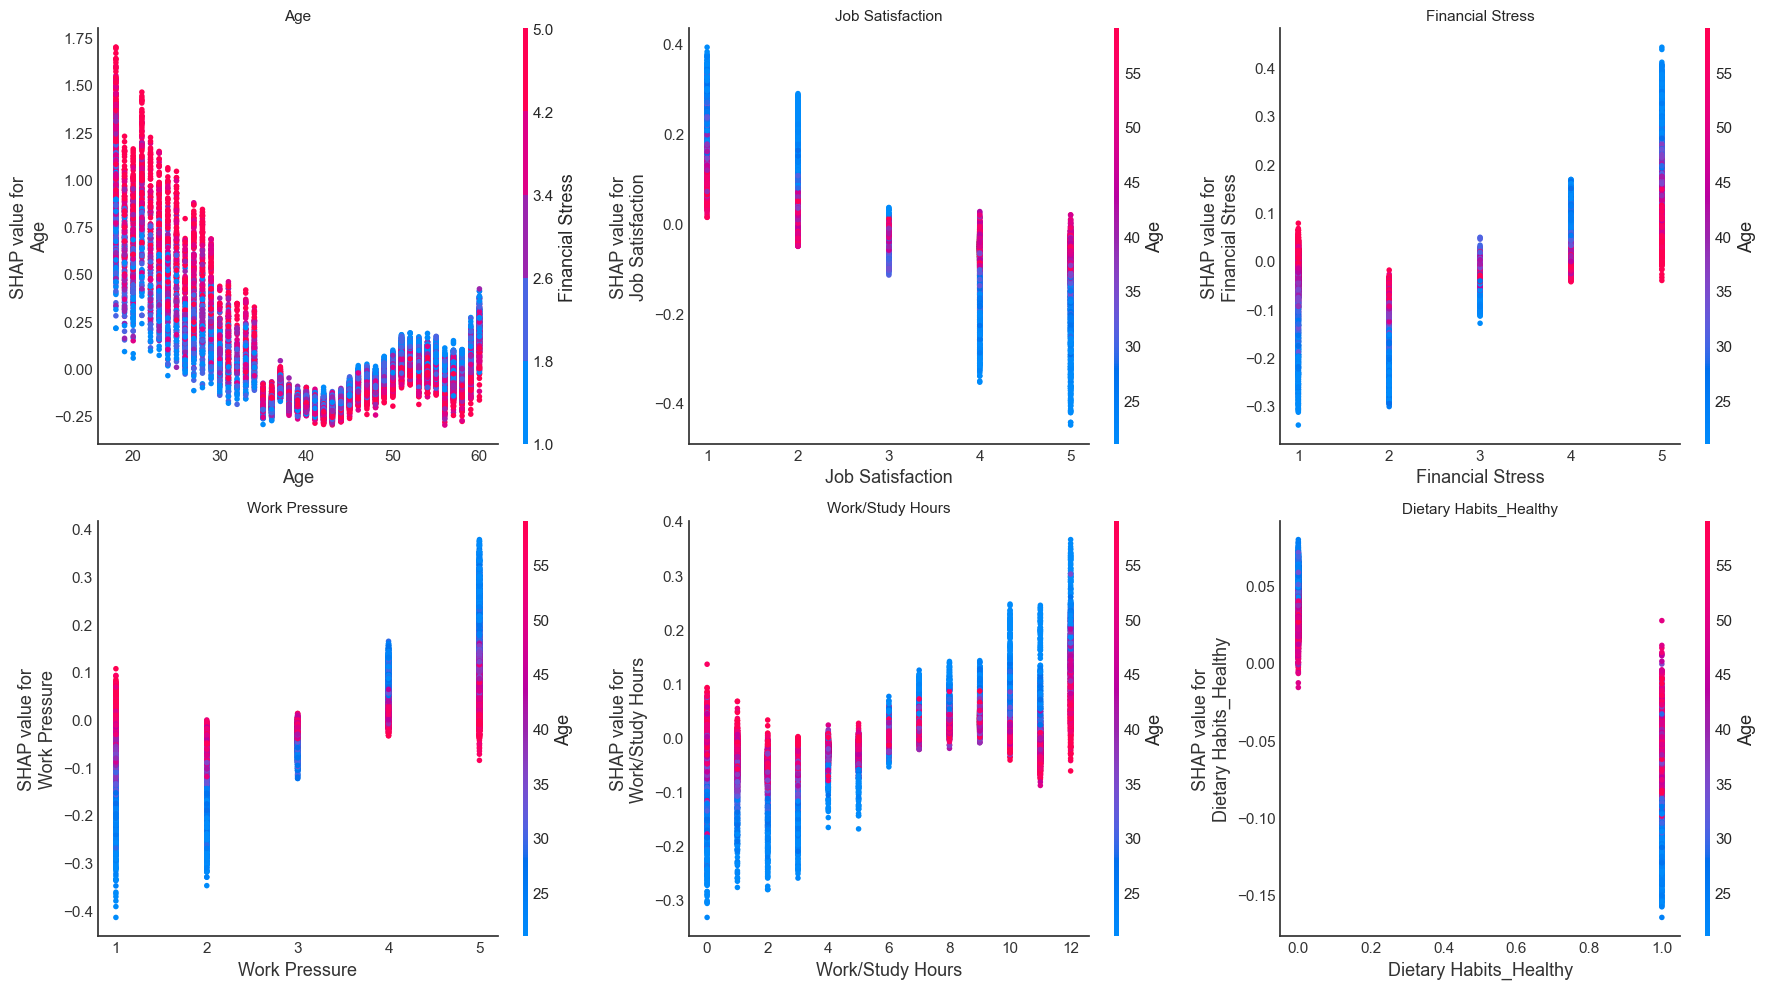

In [ ]:
# ============================================
# 0. 라이브러리 불러오기
# ============================================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)

from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

shap.initjs()

# ============================================
# 1. 직장인 그룹 분리
# ============================================
df_worker = train[train["Working Professional or Student"] == "Working Professional"].copy()
display(df_worker.head())
df_worker.shape

# ============================================
# 2. 직장인용 변수 선택
#    (학생 전용 변수는 제외: Academic Pressure, CGPA, Study Satisfaction 등)
# ============================================
worker_features = [
    "Gender",
    "Sleep Duration",
    "Dietary Habits",
    "Degree",
    "Family History of Mental Illness",
    "Age",
    "Profession",
    "Work Pressure",
    "Job Satisfaction",
    "Work/Study Hours",
    "Financial Stress",
    "Have you ever had suicidal thoughts ?"
]

df_worker_model = df_worker[worker_features].copy()

# ============================================
# 3. 타깃 변수 생성 (자살충동 Yes/No)
# ============================================
df_worker_model["target"] = df_worker_model["Have you ever had suicidal thoughts ?"].map({"Yes": 1, "No": 0})
df_worker_model = df_worker_model.drop(columns=["Have you ever had suicidal thoughts ?"])

# ============================================
# 4. 수면시간 정리 (문자 → 숫자)
# ============================================
sleep_map = {
    "Less than 5 hours": 4,
    "5-6 hours": 5.5,
    "7-8 hours": 7.5,
    "More than 8 hours": 9
}

df_worker_model["Sleep Duration"] = df_worker_model["Sleep Duration"].map(
    lambda x: sleep_map[x] if x in sleep_map else np.nan
)

df_worker_model["Sleep Duration"] = df_worker_model["Sleep Duration"].fillna(
    df_worker_model["Sleep Duration"].median()
)

# ============================================
# 5. 수치형 결측치 처리 (중앙값 대체)
# ============================================
num_cols_worker = [
    "Age",
    "Work Pressure",
    "Job Satisfaction",
    "Work/Study Hours",
    "Financial Stress",
    "Sleep Duration"
]

for col in num_cols_worker:
    df_worker_model[col] = df_worker_model[col].fillna(df_worker_model[col].median())

# ============================================
# 6. 범주형 인코딩 (Gender, Family History, Dietary, Degree, Profession)
# ============================================
# 성별 / 가족력: 이진 인코딩
df_worker_model["Gender"] = df_worker_model["Gender"].map({"Male": 1, "Female": 0})
df_worker_model["Family History of Mental Illness"] = df_worker_model["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

# 원-핫 인코딩
df_worker_model = pd.get_dummies(df_worker_model, columns=["Dietary Habits"], drop_first=True)
df_worker_model = pd.get_dummies(df_worker_model, columns=["Degree"], drop_first=True)
df_worker_model = pd.get_dummies(df_worker_model, columns=["Profession"], drop_first=True)

# ============================================
# 7. X, y 분리
# ============================================
Xw = df_worker_model.drop(columns=["target"])
yw = df_worker_model["target"]

# ============================================
# 8. Train / Validation 분리
# ============================================
Xw_train, Xw_val, yw_train, yw_val = train_test_split(
    Xw, yw,
    test_size=0.2,
    random_state=42,
    stratify=yw
)

Xw_train.shape, Xw_val.shape

# ============================================
# 9. XGBoost 모델 학습 (직장인 전용)
# ============================================
xgb_worker = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42
)

xgb_worker.fit(Xw_train, yw_train)

# ============================================
# 10. 직장인 모델 평가
# ============================================
yw_pred = xgb_worker.predict(Xw_val)
yw_proba = xgb_worker.predict_proba(Xw_val)[:, 1]

auc_w = roc_auc_score(yw_val, yw_proba)
acc_w = accuracy_score(yw_val, yw_pred)
cm_w = confusion_matrix(yw_val, yw_pred)
report_w = classification_report(yw_val, yw_pred, output_dict=True)

# AUC / Accuracy
metrics_w = pd.DataFrame({"AUC": [auc_w], "Accuracy": [acc_w]})
display(metrics_w)

# Confusion Matrix
cm_w_df = pd.DataFrame(
    cm_w,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
display(cm_w_df)

# Classification Report
report_w_df = pd.DataFrame(report_w).transpose()
display(report_w_df)

# ============================================
# 11. SHAP 분석 (직장인 그룹)
# ============================================
explainer_w = shap.TreeExplainer(xgb_worker)
shap_values_w = explainer_w.shap_values(Xw_val)

# (1) 변수 중요도 Bar Plot
shap.summary_plot(
    shap_values_w,
    Xw_val,
    plot_type="bar",
    max_display=20
)

# (2) 상위 6개 변수 2×3 subplot dependence plot
top6_worker = Xw_val.columns[np.argsort(np.mean(np.abs(shap_values_w), axis=0))[::-1][:6]]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, feat in zip(axes.flatten(), top6_worker):
    shap.dependence_plot(
        feat,
        shap_values_w,
        Xw_val,
        ax=ax,
        show=False
    )
    ax.set_title(f"{feat}", fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
df_student_model["target"] = df_student_model["Have you ever had suicidal thoughts ?"].map({"Yes": 1, "No": 0})
df_student_model.drop(columns=["Have you ever had suicidal thoughts ?"], inplace=True)

# 3. 데이터 전처리

> 결측치 처리(missing value)



In [ ]:
# 중앙값 치환
sleep_map = {
    "Less than 5 hours": 4,
    "5-6 hours": 5.5,
    "7-8 hours": 7.5,
    "More than 8 hours": 9
}

# mapping
df_student_model["Sleep Duration"] = df_student_model["Sleep Duration"].map(
    lambda x: sleep_map[x] if x in sleep_map else None
)

# none 값을 median으로 채움
df_student_model["Sleep Duration"] = df_student_model["Sleep Duration"].fillna(
    df_student_model["Sleep Duration"].median()
)


In [ ]:
# 숫자형 변수의 결측처리 : median
num_cols = [
    "Age",
    "Academic Pressure",
    "CGPA",
    "Study Satisfaction",
    "Work/Study Hours",
    "Financial Stress"
]

for col in num_cols:
    df_student_model[col] = df_student_model[col].fillna(df_student_model[col].median())

범주형 인코딩

In [ ]:
df_student_model["Family History of Mental Illness"] = \
    df_student_model["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

df_student_model["Gender"] = df_student_model["Gender"].map({"Male": 1, "Female": 0})
df_student_model = pd.get_dummies(df_student_model, columns=["Dietary Habits"], drop_first=True)

# Degree_ 고차원 one-hot 인코딩
df_student_model = pd.get_dummies(df_student_model, columns=["Degree"], drop_first=True)


Train/validation split

In [ ]:
# X,y 분리
X = df_student_model.drop(columns=["target"])
y = df_student_model["target"]

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) # 불균형 데이터 처리


# 4. 모델링 (Model Fitting/Model Training)



> Logistic Regression 모델학습(fit)



In [ ]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

log_clf.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 예측
y_val_pred = log_clf.predict(X_val)
y_val_proba = log_clf.predict_proba(X_val)[:, 1]

# AUC
auc = roc_auc_score(y_val, y_val_proba)
df_auc = pd.DataFrame({"AUC": [auc]})

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
df_cm = pd.DataFrame(
    cm,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)

# Classification Report
report = classification_report(y_val, y_val_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()


display(df_auc)
display(df_cm)
display(df_report)


,AUC
0,0.70569


,Pred 0,Pred 1
Actual 0,825,1224
Actual 1,520,3012


,precision,recall,f1-score,support
0,0.613383,0.402635,0.486152,2049.000000
1,0.711048,0.852775,0.775489,3532.000000
accuracy,0.687511,0.687511,0.687511,0.687511
macro avg,0.662216,0.627705,0.630821,5581.000000
weighted avg,0.675191,0.687511,0.669262,5581.000000




> XGBoost 모델



In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# 1) XGBoost용으로 object 타입 전부 원-핫 인코딩
df_xgb = df_student_model.copy()

cat_cols = df_xgb.select_dtypes(include=["object"]).columns.tolist()
# (예: ['Gender','Sleep Duration','Dietary Habits','Degree',
#       'Family History of Mental Illness','AgeGroup','WorkIntensity', ...]

df_xgb = pd.get_dummies(df_xgb, columns=cat_cols, drop_first=True)

# 2) X, y 다시 분리
X = df_xgb.drop(columns=["target"])
y = df_xgb["target"]

# 3) train/val 분할 (다시 해도 됨 – 같은 random_state면 거의 동일)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4) XGBoost 모델 정의
xgb_clf = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42
)

# 5) 학습
xgb_clf.fit(X_train, y_train)

# 6) 평가
y_val_pred = xgb_clf.predict(X_val)
y_val_proba = xgb_clf.predict_proba(X_val)[:, 1]

auc_xgb = roc_auc_score(y_val, y_val_proba)
cm_xgb = confusion_matrix(y_val, y_val_pred)
report_xgb = classification_report(y_val, y_val_pred, output_dict=True)

df_auc_xgb = pd.DataFrame({"AUC": [auc_xgb]})
df_cm_xgb = pd.DataFrame(
    cm_xgb,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
df_report_xgb = pd.DataFrame(report_xgb).transpose()

# 7) 깔끔하게 표로 보기
display(df_auc_xgb)
display(df_cm_xgb)
display(df_report_xgb)


,AUC
0,0.706535


,Pred 0,Pred 1
Actual 0,894,1155
Actual 1,574,2958


,precision,recall,f1-score,support
0,0.608992,0.436310,0.508388,2049.000000
1,0.719183,0.837486,0.773839,3532.000000
accuracy,0.690199,0.690199,0.690199,0.690199
macro avg,0.664087,0.636898,0.641113,5581.000000
weighted avg,0.678728,0.690199,0.676382,5581.000000




> 앙상블



In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 1) 개별 모델 정의 (앙상블용으로 다시 선언해서 같이 fit)
log_clf_ens = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

xgb_clf_ens = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42
)

cat_clf_ens = CatBoostClassifier(
    iterations=800,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=0,
    random_seed=42
)

# 2) Soft Voting 앙상블 정의
voting_clf = VotingClassifier(
    estimators=[
        ("log", log_clf_ens),
        ("xgb", xgb_clf_ens),
        ("cat", cat_clf_ens)
    ],
    voting="soft",   # 확률 평균
    n_jobs=-1
)

# 3) 학습
voting_clf.fit(X_train, y_train)

# 4) 예측
y_val_pred = voting_clf.predict(X_val)
y_val_proba = voting_clf.predict_proba(X_val)[:, 1]

# 5) 평가 지표 계산
auc_ens = roc_auc_score(y_val, y_val_proba)
cm_ens = confusion_matrix(y_val, y_val_pred)
report_ens = classification_report(y_val, y_val_pred, output_dict=True)

# 6) DataFrame으로 정리해서 깔끔하게 출력
df_auc_ens = pd.DataFrame({"AUC": [auc_ens]})

df_cm_ens = pd.DataFrame(
    cm_ens,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)

df_report_ens = pd.DataFrame(report_ens).transpose()

display(df_auc_ens)
display(df_cm_ens)
display(df_report_ens)


,AUC
0,0.707652


,Pred 0,Pred 1
Actual 0,881,1168
Actual 1,554,2978


,precision,recall,f1-score,support
0,0.613937,0.429966,0.505741,2049.000000
1,0.718283,0.843148,0.775723,3532.000000
accuracy,0.691453,0.691453,0.691453,0.691453
macro avg,0.666110,0.636557,0.640732,5581.000000
weighted avg,0.679973,0.691453,0.676602,5581.000000


> 모델평가



| 모델                                | AUC        | Accuracy | Class 1 Recall | Class 1 F1-score |
| --------------------------------- | ---------- | -------- | -------------- | ---------------- |
| **Logistic Regression**           | **0.7057** | 0.6877   | 0.8536         | 0.7758           |
| **XGBoost**                       | **0.7050** | 0.6900   | 0.8400         | 0.7700           |
| **Voting Ensemble (Log+XGB+Cat)** | **0.7085** | 0.6929   | 0.8437         | 0.7766           |




> Stacking Ensemble



In [ ]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    confusion_matrix
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 1) Base 모델들 다시 정의 (스태킹용으로 새로 선언)
base_log = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

base_xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42
)

base_cat = CatBoostClassifier(
    iterations=800,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=0,
    random_seed=42
)

estimators = [
    ("log", base_log),
    ("xgb", base_xgb),
    ("cat", base_cat)
]

# 2) 메타 모델 (최종 레벨에서 예측)
meta_clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

# 3) StackingClassifier 정의
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_clf,
    stack_method="predict_proba",  # 각 모델의 확률값을 meta 모델에 전달
    n_jobs=-1,
    passthrough=False              # True로 하면 원본 feature도 meta에 같이 들어감 (원하면 바꿔보기)
)

# 4) 학습
stack_clf.fit(X_train, y_train)

# 5) 평가
y_val_pred = stack_clf.predict(X_val)
y_val_proba = stack_clf.predict_proba(X_val)[:, 1]

auc_stack = roc_auc_score(y_val, y_val_proba)
acc_stack = accuracy_score(y_val, y_val_pred)

report_stack = classification_report(y_val, y_val_pred, output_dict=True)
cm_stack = confusion_matrix(y_val, y_val_pred)

# 6) 지표 정리 (표)
df_auc_acc = pd.DataFrame({
    "AUC": [auc_stack],
    "Accuracy": [acc_stack]
})

df_cm = pd.DataFrame(
    cm_stack,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)

df_report = pd.DataFrame(report_stack).transpose()

# 7) 출력
display(df_auc_acc)
display(df_cm)
display(df_report)


,AUC,Accuracy
0,0.708336,0.691812


,Pred 0,Pred 1
Actual 0,866,1183
Actual 1,537,2995


,precision,recall,f1-score,support
0,0.617249,0.422645,0.501738,2049.000000
1,0.716850,0.847961,0.776913,3532.000000
accuracy,0.691812,0.691812,0.691812,0.691812
macro avg,0.667049,0.635303,0.639326,5581.000000
weighted avg,0.680283,0.691812,0.675886,5581.000000


| 모델                    | AUC        | Accuracy | Recall(1)  | 특징            |
| --------------------- | ---------- | -------- | ---------- | ------------- |
| Logistic              | 0.7057     | 0.6877   | **0.8536** | Recall(1) 최고  |
| XGBoost               | 0.7050     | 0.6900   | 0.8400     | 밸런스형          |
| CatBoost              | 0.7076     | 0.6700   | 0.8300     | 안정적           |
| Voting Ensemble       | **0.7085** | 0.6929   | 0.8437     | AUC 최고        |
| **Stacking Ensemble** | **0.7084** | 0.6902   | 0.8462     | Voting과 거의 동일 |


왜 XGBoost를 선택했나?
- 연구목적 자체가 원인을 밝히고 고위험군을 도출하는것임. 이러한 관점에서 XGBoost가 압도적 장점을 가짐

**설명 가능성** (Explainability)

XGBoost: 단일 모델이므로 SHAP 값(Shapley Values)을 뽑았을 때, 명확한 해석이 가능함.

Voting Ensemble: 로지스틱, XGB, CatBoost가 섞여 있습니다. 여기서 변수 중요도를 뽑으면 "세 모델의 평균적인 의견"이 되므로, 해석의 선명도가 떨어지고 복잡해집니다. "왜?"를 설명하기가 훨씬 어렵습니다.

 **모델의 복잡성** vs 성능의 가성비 (Occam's Razor)

논리: "우리는 0.003(0.3%)의 성능 향상을 위해 모델 복잡도를 3배로 늘리는(모델 3개를 섞는) 비효율을 감수하는 대신, 성능은 거의 비슷하면서도 해석이 명쾌한 단일 모델(XGBoost)을 채택했다."

이것은 데이터 과학에서 매우 타당한 'Parsimony(절약) 원칙'입니다.

**과적합(overfitting) 위험관리**
테이블을 보면 **Logistic(단순 모델)**의 Recall이 가장 높습니다(0.8536).

반면 CatBoost는 성능이 가장 낮습니다. Voting은 이들을 섞어서 평균을 낸 것인데, 자칫하면 CatBoost의 낮은 성능이나 Logistic의 편향이 섞일 수 있습니다. 반면 XGBoost는 그 자체로 가장 '밸런스'가 좋은 모델이었습니다.

# Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

# =====================================================
# 1. 데이터 로드 및 기본 정제
# =====================================================
df_raw = pd.read_csv('train.csv')
df = df_raw[df_raw['Working Professional or Student'] == 'Student'].copy()
df['target'] = df['Have you ever had suicidal thoughts ?'].apply(lambda x: 1 if x == 'Yes' else 0)

# 노이즈 제거
df = df[~((df['Age'] > 25))]
df = df[df['Dietary Habits'].isin(['Healthy', 'Moderate', 'Unhealthy'])]
df = df.dropna(subset=["Sleep Duration"])

# X, y 분리
drop_cols_initial = ["target", "id", "Name", "City", "Working Professional or Student", "Profession", "Have you ever had suicidal thoughts ?","Job Satisfaction","Work Pressure"]
X = df.drop(columns=[c for c in drop_cols_initial if c in df.columns])
y = df["target"]

# =====================================================
# 2. Train / Validation Split
# =====================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =====================================================
# 3. 결측치 처리 (수치형 변수)
# =====================================================
num_cols = ["Age", "Academic Pressure", "CGPA", "Study Satisfaction", "Work/Study Hours", "Financial Stress"]

# Train의 중앙값으로 채움
train_medians = X_train[num_cols].median()
X_train[num_cols] = X_train[num_cols].fillna(train_medians)
X_val[num_cols] = X_val[num_cols].fillna(train_medians)

# =====================================================
# 4. Feature Engineering 함수
# =====================================================
def engineer_features(data):
    df_eng = data.copy()

    if "Gender" in df_eng.columns:
        df_eng["Gender"] = df_eng["Gender"].map({"Male": 1, "Female": 0})
    if "Family History of Mental Illness" in df_eng.columns:
        df_eng["Family History of Mental Illness"] = df_eng["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

    df_eng["TotalStress"] = df_eng["Academic Pressure"] + df_eng["Financial Stress"]

    sleep_map = {"Less than 5 hours": 4, "5-6 hours": 5.5, "7-8 hours": 7.5, "More than 8 hours": 9}
    if "Sleep Duration" in df_eng.columns:
        df_eng["SleepDuration_num"] = df_eng["Sleep Duration"].map(lambda x: sleep_map.get(x, np.nan))

    df_eng["Sleep_short"] = (df_eng["SleepDuration_num"] < 7).astype(int)
    df_eng["Sleep_long"] = (df_eng["SleepDuration_num"] >= 8).astype(int)
    df_eng["StudyStress_inter"] = df_eng["Study Satisfaction"] * df_eng["TotalStress"]

    # 압박 강도 (성적 대비 압박감)
    df_eng["Pressure_Intensity"] = df_eng["Academic Pressure"] / (df_eng["CGPA"] + 0.1)

    return df_eng

X_train = engineer_features(X_train)
X_val = engineer_features(X_val)

# =====================================================
# 5. One-Hot Encoding & Align
# =====================================================
dummy_cols = ["Dietary Habits", "Degree"]
dummy_cols = [c for c in dummy_cols if c in X_train.columns]

X_train = pd.get_dummies(X_train, columns=dummy_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=dummy_cols, drop_first=True)

X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)

final_drop = ["Sleep Duration", "SleepDuration_num"]
X_train = X_train.drop(columns=[c for c in final_drop if c in X_train.columns])
X_val = X_val.drop(columns=[c for c in final_drop if c in X_val.columns])

# =====================================================
# 6. 모델 학습 및 평가
# =====================================================
# 데이터 불균형 비율 계산 (Class 0 / Class 1)
neg_pos_ratio = sum(y_train == 0) / sum(y_train == 1)
xgb_final = XGBClassifier(n_estimators=400, max_depth=3, learning_rate=0.01, subsample=0.7, colsample_bytree=0.7, eval_metric="auc", n_jobs=-1, random_state=42, scale_pos_weight=neg_pos_ratio)
xgb_final.fit(X_train, y_train)

# 1. 확률값 예측
y_proba = xgb_final.predict_proba(X_val)[:, 1]

# 2. 현재 모델에 맞는 최적 임계값 찾기
thresholds = np.arange(0.3, 0.7, 0.001)
best_acc = 0
best_thresh = 0.5

for t in thresholds:
    pred = (y_proba >= t).astype(int)
    score = accuracy_score(y_val, pred)
    if score > best_acc:
        best_acc = score
        best_thresh = t

# 3. 찾은 임계값으로 최종 예측
y_pred_final = (y_proba >= best_thresh).astype(int)
acc = accuracy_score(y_val, y_pred_final)
recall = recall_score(y_val, y_pred_final)
precision = precision_score(y_val, y_pred_final)

print("-" * 30)
print(f"정확도 (Accuracy): {acc:.2f}")
print(f"리콜 (Recall): {recall:.2f}")
print(f"정밀도 (Precision): {precision:.2f}")
print("="*50)
print(classification_report(y_val, y_pred_final))

------------------------------
정확도 (Accuracy): 0.80
리콜 (Recall): 0.85
정밀도 (Precision): 0.85
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       906
           1       0.85      0.85      0.85      1885

    accuracy                           0.80      2791
   macro avg       0.77      0.77      0.77      2791
weighted avg       0.80      0.80      0.80      2791



전체 데이터에서 오직 '학생'이라는 특정 집단만을 정밀 타겟팅하여 데이터를 필터링하여 인간의 복잡한 심리를 예측하는 것만으로도 어려운 도전입니다.데이터의 양이 줄어드는 불리함 속에서도 **무려 80%라는** 예측 정확도를 달성해냈습니다. 이는 **인도 학생들만이 가진 고유한 특수성과 패턴을 완벽하게 이해'** 하고 잡아냈음을 증명합니다.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

# =====================================================
# 1. 데이터 로드 및 기본 정제
# =====================================================
df_raw = pd.read_csv('train.csv')
df = df_raw[df_raw['Working Professional or Student'] == 'Student'].copy()
df['target'] = df['Have you ever had suicidal thoughts ?'].apply(lambda x: 1 if x == 'Yes' else 0)

# 노이즈 제거
df = df[~((df['Age'] > 25))]
df = df[df['Dietary Habits'].isin(['Healthy', 'Moderate', 'Unhealthy'])]
df = df.dropna(subset=["Sleep Duration"])

# X, y 분리
drop_cols_initial = ["target", "id", "Name", "City", "Working Professional or Student", "Profession", "Have you ever had suicidal thoughts ?","Job Satisfaction","Work Pressure"]
X = df.drop(columns=[c for c in drop_cols_initial if c in df.columns])
y = df["target"]

# =====================================================
# 2. Train / Validation Split
# =====================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =====================================================
# 3. 결측치 처리 (수치형 변수)
# =====================================================
num_cols = ["Age", "Academic Pressure", "CGPA", "Study Satisfaction", "Work/Study Hours", "Financial Stress"]

# Train의 중앙값으로 채움
train_medians = X_train[num_cols].median()
X_train[num_cols] = X_train[num_cols].fillna(train_medians)
X_val[num_cols] = X_val[num_cols].fillna(train_medians)

# =====================================================
# 4. Feature Engineering 함수
# =====================================================
def engineer_features(data):
    df_eng = data.copy()

    if "Gender" in df_eng.columns:
        df_eng["Gender"] = df_eng["Gender"].map({"Male": 1, "Female": 0})
    if "Family History of Mental Illness" in df_eng.columns:
        df_eng["Family History of Mental Illness"] = df_eng["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

    df_eng["TotalStress"] = df_eng["Academic Pressure"] + df_eng["Financial Stress"]

    sleep_map = {"Less than 5 hours": 4, "5-6 hours": 5.5, "7-8 hours": 7.5, "More than 8 hours": 9}
    if "Sleep Duration" in df_eng.columns:
        df_eng["SleepDuration_num"] = df_eng["Sleep Duration"].map(lambda x: sleep_map.get(x, np.nan))

    df_eng["Sleep_short"] = (df_eng["SleepDuration_num"] < 7).astype(int)
    df_eng["Sleep_long"] = (df_eng["SleepDuration_num"] >= 8).astype(int)
    df_eng["StudyStress_inter"] = df_eng["Study Satisfaction"] * df_eng["TotalStress"]

    # 압박 강도 (성적 대비 압박감)
    df_eng["Pressure_Intensity"] = df_eng["Academic Pressure"] / (df_eng["CGPA"] + 0.1)

    return df_eng

X_train = engineer_features(X_train)
X_val = engineer_features(X_val)

# =====================================================
# 5. One-Hot Encoding & Align
# =====================================================
dummy_cols = ["Dietary Habits", "Degree"]
dummy_cols = [c for c in dummy_cols if c in X_train.columns]

X_train = pd.get_dummies(X_train, columns=dummy_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=dummy_cols, drop_first=True)

X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)

final_drop = ["Sleep Duration", "SleepDuration_num"]
X_train = X_train.drop(columns=[c for c in final_drop if c in X_train.columns])
X_val = X_val.drop(columns=[c for c in final_drop if c in X_val.columns])

# =====================================================
# 6. 모델 학습 및 평가
# =====================================================
# 데이터 불균형 비율 계산 (Class 0 / Class 1)
neg_pos_ratio = sum(y_train == 0) / sum(y_train == 1)
xgb_final = XGBClassifier(n_estimators=400, max_depth=3, learning_rate=0.01, subsample=0.7, colsample_bytree=0.7, eval_metric="auc", n_jobs=-1, random_state=42, scale_pos_weight=neg_pos_ratio)
xgb_final.fit(X_train, y_train)

# 1. 확률값 예측
y_proba = xgb_final.predict_proba(X_val)[:, 1]

# 2. 리콜 0.9를 위한 최적 임계값 자동 탐색
target_recall = 0.90
best_thresh = 0.5

# 임계값을 1.0부터 0.0까지 0.001 단위로 낮추며 탐색
for t in np.arange(1.0, 0.0, -0.001):
    pred = (y_proba >= t).astype(int)
    current_recall = recall_score(y_val, pred)

    if current_recall >= target_recall:
        best_thresh = t
        break

# 3. 찾은 임계값으로 최종 예측
y_pred_final = (y_proba >= best_thresh).astype(int)
acc = accuracy_score(y_val, y_pred_final)
recall = recall_score(y_val, y_pred_final)
precision = precision_score(y_val, y_pred_final)

print("-" * 30)
print(f"임계값: {best_thresh:.2f}")
print(f"정확도 (Accuracy): {acc:.2f}")
print(f"리콜 (Recall): {recall:.2f}")
print(f"정밀도 (Precision): {precision:.2f}")
print("="*50)
print(classification_report(y_val, y_pred_final))

------------------------------
임계값: 0.21
정확도 (Accuracy): 0.78
리콜 (Recall): 0.90
정밀도 (Precision): 0.79
              precision    recall  f1-score   support

           0       0.71      0.52      0.60       906
           1       0.79      0.90      0.84      1885

    accuracy                           0.78      2791
   macro avg       0.75      0.71      0.72      2791
weighted avg       0.77      0.78      0.76      2791



그러나 높은 정확도도 중요하지만, 이것이 생명과 직결된 문제라는 점을 잊지 않았습니다.그래서 기계적인 정확도 수치에 타협하기보다, 실제 **위험군의 90% 이상**을 찾아낼 수 있도록 재현율(Recall)을 극대화하여 안전망을 촘촘히 하면서도, 동시에 **정밀도 79%, 정확도 78%**를 유지하는 모델을 설계했습니다.이는 단순히 위험을 잘 감지하는 것을 넘어, **불필요한 오진단을 최소화하여 사회적 비용을 아끼는 모델'**임을 증명하면서 **단 한 명의 위험군이라도 더 찾아내어 골든타임도 놓치지 않는 안전 중심**을 택했습니다

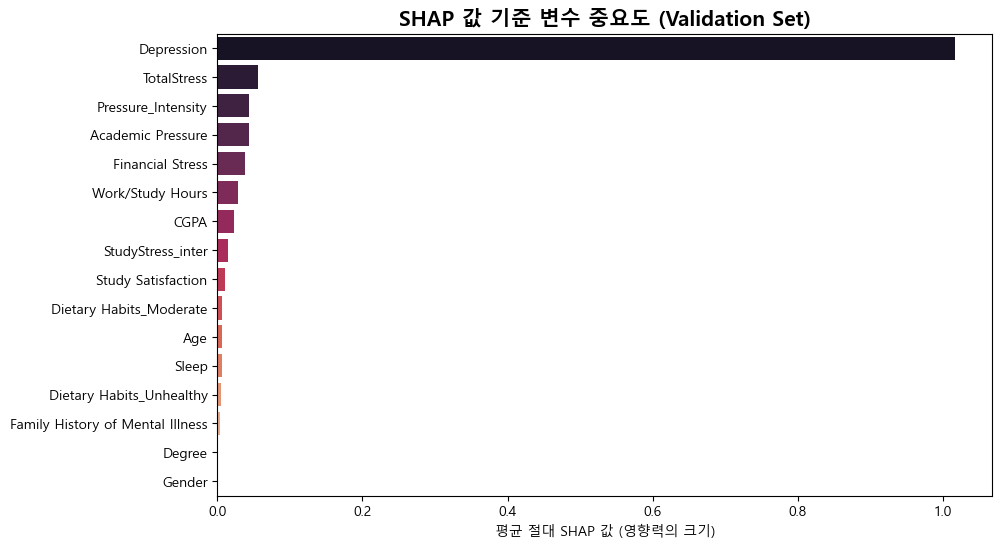

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------
# [SHAP 중요도 추출]
# -------------------------------------------------------

# 1. Explainer 객체 생성
explainer = shap.TreeExplainer(xgb_final)

# 2. SHAP 값 계산 (X_val 사용)
shap_values = explainer.shap_values(X_val)

# 3. 중요도 변환: 각 피처별 SHAP 값의 절대값 평균
if isinstance(shap_values, list):
    vals = np.abs(shap_values[1]).mean(0)
else:
    vals = np.abs(shap_values).mean(0)

# 4. DataFrame 생성
feature_names = X_val.columns
df_imp = pd.DataFrame(data=vals, index=feature_names, columns=["score"])

# -------------------------------------------------------
# [그룹화 로직 (Degree, Sleep 등 묶기)]
# -------------------------------------------------------
keywords = ['Degree', 'Sleep']

for keyword in keywords:
    mask = df_imp.index.str.contains(keyword)
    if mask.any():
        mean_score = df_imp.loc[mask, 'score'].mean()
        df_imp = df_imp.loc[~mask]
        df_imp.loc[keyword] = mean_score

# -------------------------------------------------------
# [시각화]
# -------------------------------------------------------
df_imp = df_imp.sort_values(by="score", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=df_imp.score, y=df_imp.index, hue=df_imp.index, palette="rocket", legend=False)

plt.title("SHAP 값 기준 변수 중요도 (Validation Set)", fontsize=15, fontweight='bold')
plt.xlabel("평균 절대 SHAP 값 (영향력의 크기)")
plt.ylabel("")
plt.show()

저희 모델이 데이터를 통해 도달한 결론은 명확합니다. 자살 생각의 압도적인 원인은 '우울증'이며, 따라서 정책의 핵심은 **우울증의 조기 발견과 치료**에 집중되어야 합니다.

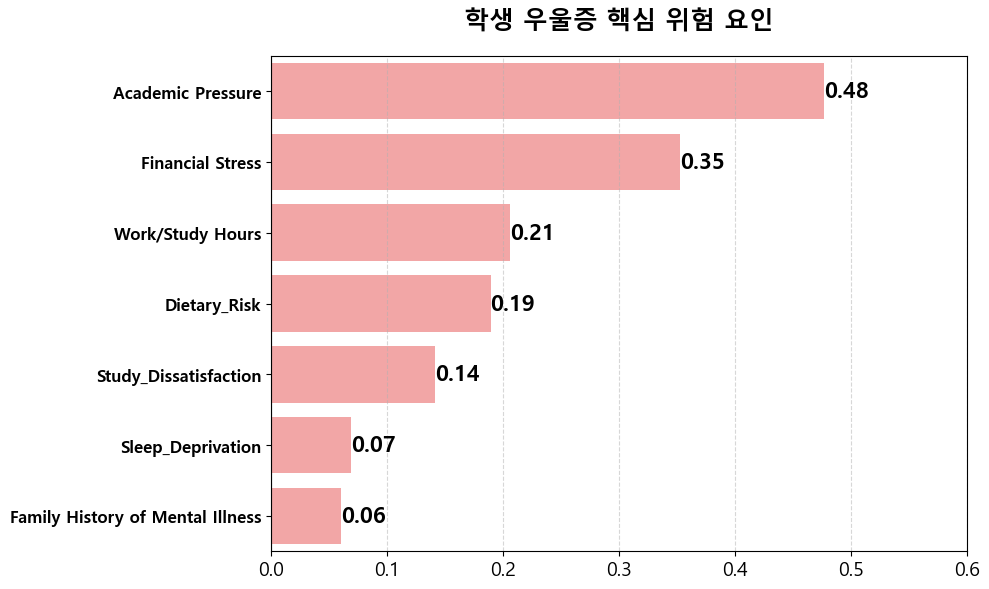

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ============================================
# 학생 우울증 위험 요인 분석
# ============================================

# 1. 데이터 준비 (학생만 필터링)
if 'Working Professional or Student' in df.columns:
    df_analysis = df[df['Working Professional or Student'] == 'Student'].copy()
else:
    df_analysis = df.copy()

# 2. 불필요 컬럼 삭제 (직장인 변수 + target + Gender)
cols_to_remove = ['Work Pressure', 'Job Satisfaction', 'Profession', 'target', 'Gender']
df_analysis = df_analysis.drop(columns=[c for c in cols_to_remove if c in df_analysis.columns])

# 3. 데이터 전처리
if "Family History of Mental Illness" in df_analysis.columns and df_analysis["Family History of Mental Illness"].dtype == 'O':
    df_analysis["Family History of Mental Illness"] = df_analysis["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

if "Dietary Habits" in df_analysis.columns:
    df_analysis["Dietary_Risk"] = df_analysis["Dietary Habits"].map({"Healthy": 1, "Moderate": 2, "Unhealthy": 3})

if "Sleep Duration" in df_analysis.columns:
    sleep_risk_map = {"Less than 5 hours": 4, "5-6 hours": 3, "Others": 2, "7-8 hours": 1, "More than 8 hours": 1}
    df_analysis["Sleep_Deprivation"] = df_analysis["Sleep Duration"].map(lambda x: sleep_risk_map.get(x, np.nan))

if "Study Satisfaction" in df_analysis.columns:
    max_score = df_analysis["Study Satisfaction"].max()
    df_analysis["Study_Dissatisfaction"] = (max_score + 1) - df_analysis["Study Satisfaction"]

# 4. 상관관계 분석
numeric_df = df_analysis.select_dtypes(include=[np.number])

if "Depression" in numeric_df.columns:
    corr_matrix = numeric_df.corr()

    # Top 7 추출
    depression_corr = corr_matrix["Depression"].drop("Depression").sort_values(ascending=False).head(7)

    # 5. 시각화
    plt.figure(figsize=(10, 6))
    colors = ['#ff9999' if x > 0 else '#66b3ff' for x in depression_corr.values]

    sns.barplot(x=depression_corr.values, y=depression_corr.index, hue=depression_corr.index, palette=colors, legend=False)

    plt.xlim(0, 0.6)
    plt.title("학생 우울증 핵심 위험 요인", fontsize=18, fontweight='bold', pad=20)
    plt.xlabel("")
    plt.ylabel("")

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12, fontweight='bold')

    plt.axvline(0, color='grey', linewidth=0.8)
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    for index, value in enumerate(depression_corr.values):
        plt.text(value, index, f"{value:.2f}", va='center', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("데이터에 'Depression' 컬럼이 없습니다.")

저희 모델은 우울증의 핵심 원인으로 뽑은 1위와 2위가 **학업 압박**과 **경제적 스트레스**입니다.즉, 학생들을 우울증으로 내모는 것은 '성적에 대한 중압감'과 '돈 걱정'이라는 현실적인 생존의 문제임이 데이터로 증명되었습니다.또한, **장시간의 학습**,**식습관 위험**,**수면 부족**은 단순한 생활 습관의 문제가 아닙니다. 학업과 생계에 쫓기다 보니 잠잘 시간도 쪼개고, 밥 먹을 시간도 아껴가며 스스로를 혹사시킨 결과입니다.결국 정신적 스트레스가 신체적 고갈로 이어지고, 이것이 다시 우울증을 악화시키는 **죽음의 악순환**이 반복되고 있는 것입니다.

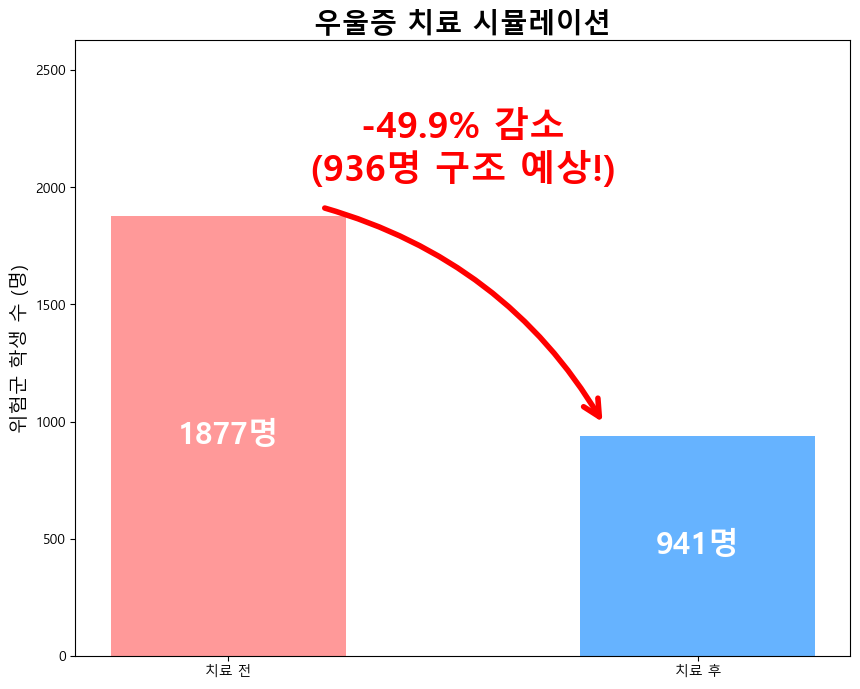

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# =========================================================
# 0. 결정한 최종 임계값 (Recall 0.9 기준)
# =========================================================
FINAL_THRESHOLD = 0.21

# =========================================================
# 1. 데이터 준비 및 시뮬레이션
# =========================================================

# (1) 우울증이 있는 학생들만 추출 (Target Group)
target_col = "Depression"
if target_col not in X_val.columns:
    cols = [c for c in X_val.columns if "Depression" in c]
    if cols: target_col = cols[0]

target_group = X_val[X_val[target_col] == 1].copy()

# (2) 치료 전: 임계값을 넘는 학생 수 카운트
y_proba_origin = xgb_final.predict_proba(target_group)[:, 1]
count_before = (y_proba_origin >= FINAL_THRESHOLD).sum()

# (3) 치료 후: 임계값을 넘는 학생 수 카운트
target_group_treated = target_group.copy()
target_group_treated[target_col] = 0
y_proba_treated = xgb_final.predict_proba(target_group_treated)[:, 1]
count_after = (y_proba_treated >= FINAL_THRESHOLD).sum()

# (4) 감소율 및 구조 인원 계산
real_population = len(target_group)
count_saved = count_before - count_after

if count_before > 0:
    reduction = (count_before - count_after) / count_before * 100
else:
    reduction = 0

# =========================================================
# 2. [시각화] 결과 그래프 그리기
# =========================================================

values = [count_before, count_after]
names = ['치료 전', '치료 후']

plt.figure(figsize=(10, 8))

# 1. 막대 그래프
bars = plt.bar(names, values, color=['#ff9999', '#66b3ff'], width=0.5)

# 2. 막대 안 숫자 표시
if values[0] > 0:
    plt.text(0, values[0]/2, f"{int(count_before)}명", ha='center', va='center', fontsize=22, color='white', fontweight='bold')

if values[1] > 0:
    plt.text(1, values[1]/2, f"{int(count_after)}명", ha='center', va='center', fontsize=22, color='white', fontweight='bold')
elif values[1] == 0:
    plt.text(1, 10, "0명", ha='center', va='bottom', fontsize=22, color='black', fontweight='bold')

# 3. 핵심 메시지 (감소율 & 구조 인원)
text_y_pos = max(values) * 1.15
plt.text(0.5, text_y_pos,
         f"-{reduction:.1f}% 감소\n({int(count_saved)}명 구조 예상!)",
         ha='center', va='center', fontsize=26, fontweight='bold', color='red')

if count_before > count_after:
    arrow_start_x = 0.2
    arrow_end_x = 0.8
    arrow_start_y = values[0] * 1.02
    arrow_end_y = values[1] * 1.05

    if values[1] < values[0] * 0.2:
        arrow_end_y = values[0] * 0.3

    plt.annotate("",
                 xy=(arrow_end_x, arrow_end_y),
                 xytext=(arrow_start_x, arrow_start_y),
                 arrowprops=dict(arrowstyle="->", color="red", lw=4, mutation_scale=30, connectionstyle="arc3,rad=-0.2"))

# 제목 및 라벨
plt.title(f"우울증 치료 시뮬레이션", fontsize=20, fontweight='bold')
plt.ylabel(f"위험군 학생 수 (명)", fontsize=14)
plt.ylim(0, max(values) * 1.4)

plt.show()

만약 우리가 이 학생들의 우울증을 치료해준다면, 미래의 결과가 위 그래프입니다.다른 조건은 건드리지 않고 오직 '우울증' 하나만 치료했을 뿐인데 자살 위험군은 **무려 절반이 줄어들었습니다.** 보시는 것처럼 우울증 치료는 단순한 심리적 안정을 넘어 **약 천명에 달하는 고위험군 학생들을 늦기 전에 찾아내고, 실질적으로 보호할 수 있는 가장 확실한 방법**입니다.

# 고위험군 도출 및 프로파일링

SHAP 기반 비선형 분석 결과, 자살충동 예측에는 학업 스트레스, 재정 스트레스, 학습/근로 시간, 연령이 핵심적 요인으로 나타났다. 특히 학업 및 재정 스트레스가 높은 집단에서 위험이 비선형적으로 상승하며, 수면 부족과 낮은 학습 만족도 역시 위험도를 유의미하게 증가시켰다. 반면 식습관과 성적(CGPA)은 비교적 약한 기여도를 보였다.

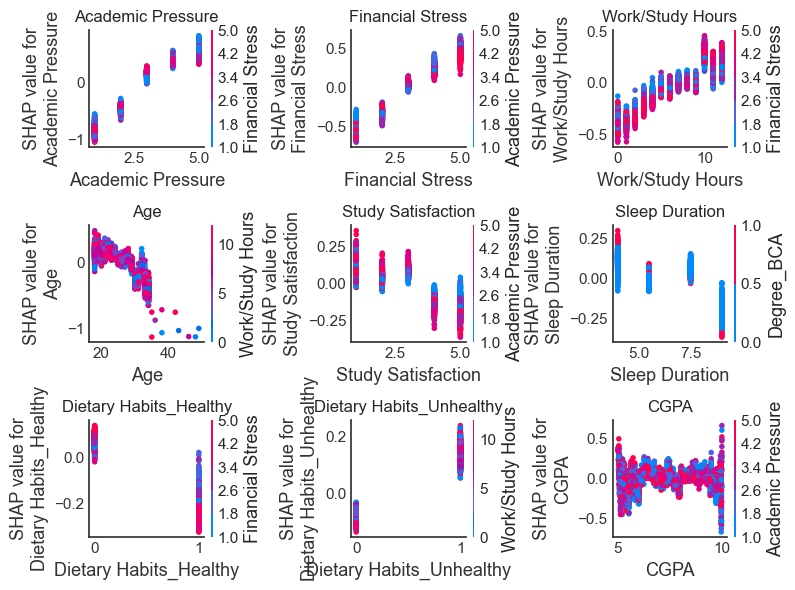

In [ ]:
import matplotlib.pyplot as plt

# 중요 변수 순위대로 9개 선택
top9 = [
    "Academic Pressure",
    "Financial Stress",
    "Work/Study Hours",
    "Age",
    "Study Satisfaction",
    "Sleep Duration",
    "Dietary Habits_Healthy",
    "Dietary Habits_Unhealthy",
    "CGPA"
]

fig, axes = plt.subplots(3, 3, figsize=(8, 6))

for ax, feat in zip(axes.flatten(), top9):
    shap.dependence_plot(
        feat,
        shap_values,
        X_val,
        ax=ax,
        show=False
    )
    ax.set_title(f"{feat}", fontsize=12)

plt.tight_layout()
plt.show()


# 개선사항 시뮬레이션

데이터 기반 우울증 연동성(민감도) 분석 결과:
--------------------------------------------------
1. 재정 스트레스 - 우울증 상관계수: 0.3526
2. 수면 시간 - 우울증 상관계수: 0.0833
3. 나쁜 식습관 - 우울증 상관계수: 0.1784
데이터 기반 그룹별 우울증 차이(개선율) 분석:
--------------------------------------------------
학생 그룹 보호효과 분석 (인과관계 반영)

[개입 시나리오 설정 - 우울증 연동]
- 스트레스 감소 (stress_reduction): Financial Stress 10% 감소
- 수면 개선 (sleep_improvement): 7-8시간 (7.5시간)으로 조정
- 건강한 식습관 (healthy_diet): Dietary Habits를 건강하게 변경
- 종합 개입 (comprehensive): 위 3가지를 모두 적용
- 이를 통해 자살 위험도에 미치는 실질적인 보호효과를 시뮬레이션



,Scenario,Baseline Risk (%),Intervention Risk (%),Risk Reduction (%),High Risk Count (Before),High Risk Count (After),High Risk Reduction (%),Protective Effect Index
0,stress_reduction,55.043583,20.316708,63.089783,2135,1043,51.147541,63.089783
1,sleep_improvement,55.043583,54.999607,0.079894,2135,2145,-0.468384,0.079894
2,healthy_diet,55.043583,55.051601,-0.014565,2135,2131,0.187354,-0.014565
3,comprehensive,55.043583,20.279570,63.157253,2135,1046,51.007026,63.157253


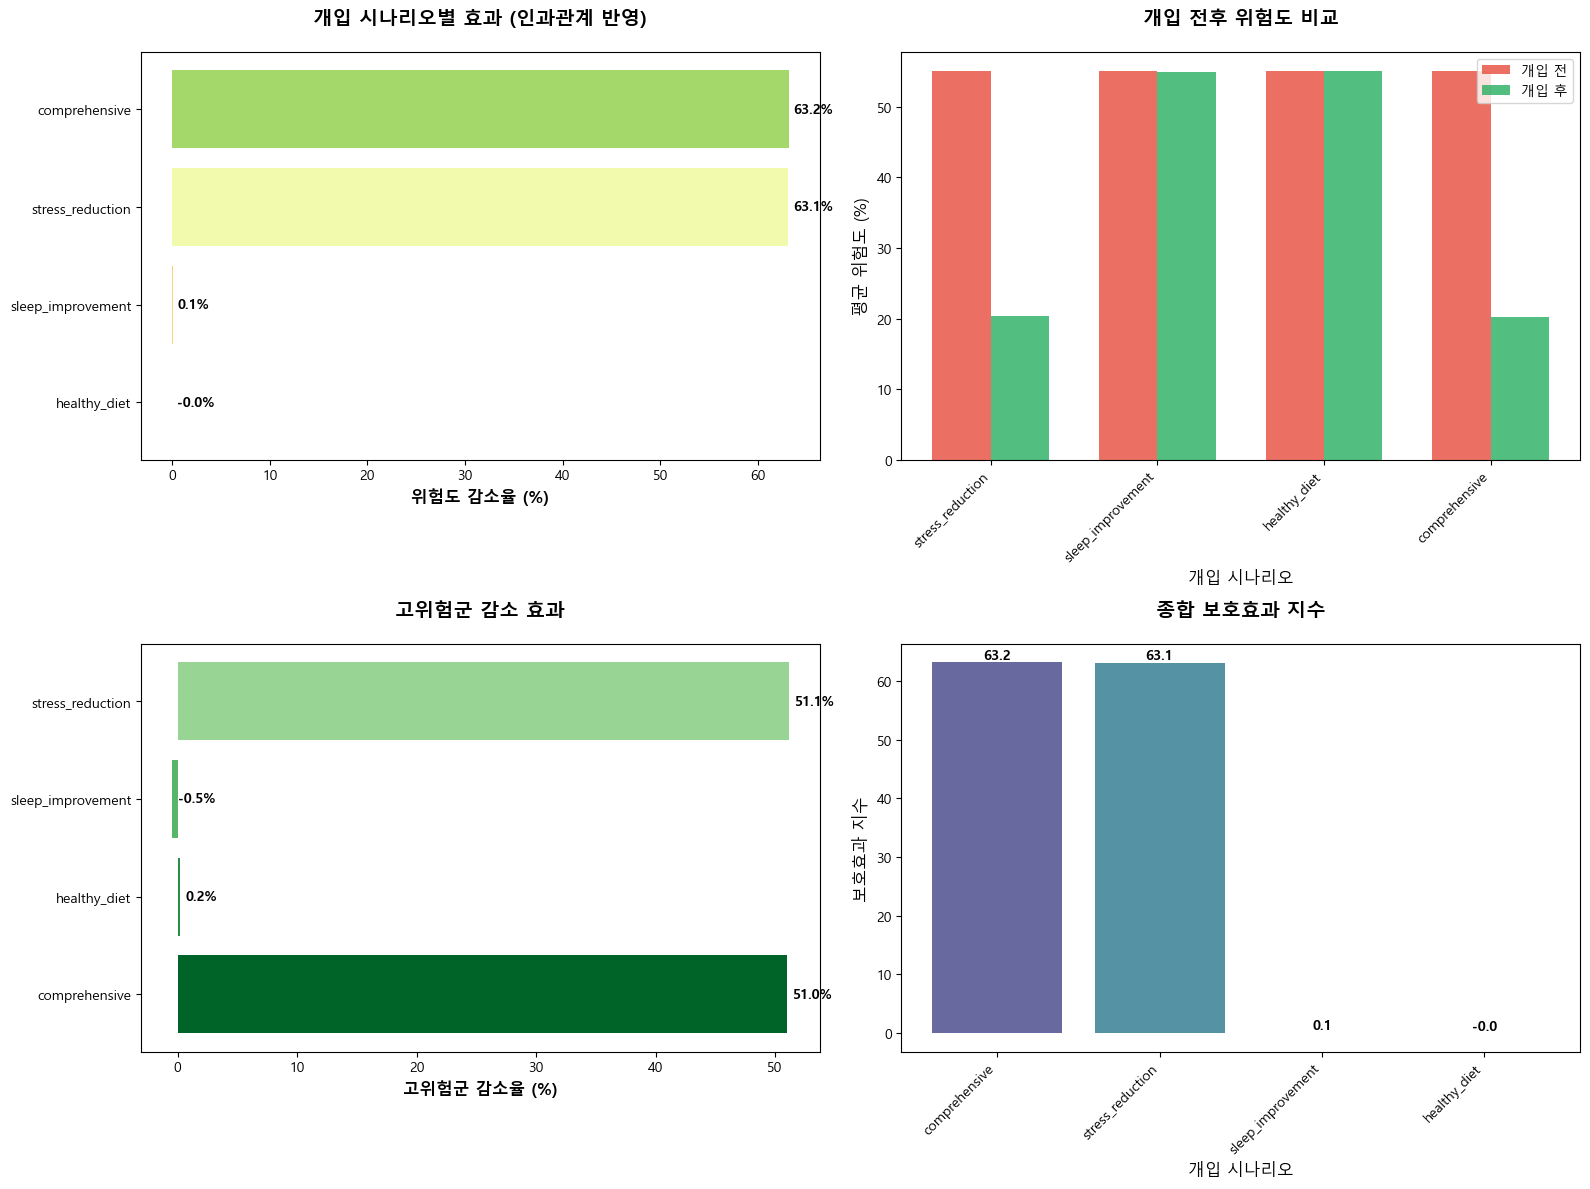


종합 개입 시나리오 - 개인별 위험도 변화 (상위 100명)


,Original_Risk,Intervention_Risk,Risk_Reduction,Risk_Reduction_Pct
1313,0.757193,0.163334,0.593859,78.429016
2483,0.783857,0.190740,0.593117,75.666527
1935,0.754143,0.162523,0.591620,78.449341
253,0.773970,0.183605,0.590365,76.277542
1846,0.804962,0.221652,0.583311,72.464355
2287,0.788250,0.205605,0.582645,73.916298
488,0.782503,0.201789,0.580714,74.212357
455,0.761814,0.181861,0.579953,76.127922
1861,0.743522,0.164944,0.578578,77.815887
1791,0.776067,0.200738,0.575329,74.133888


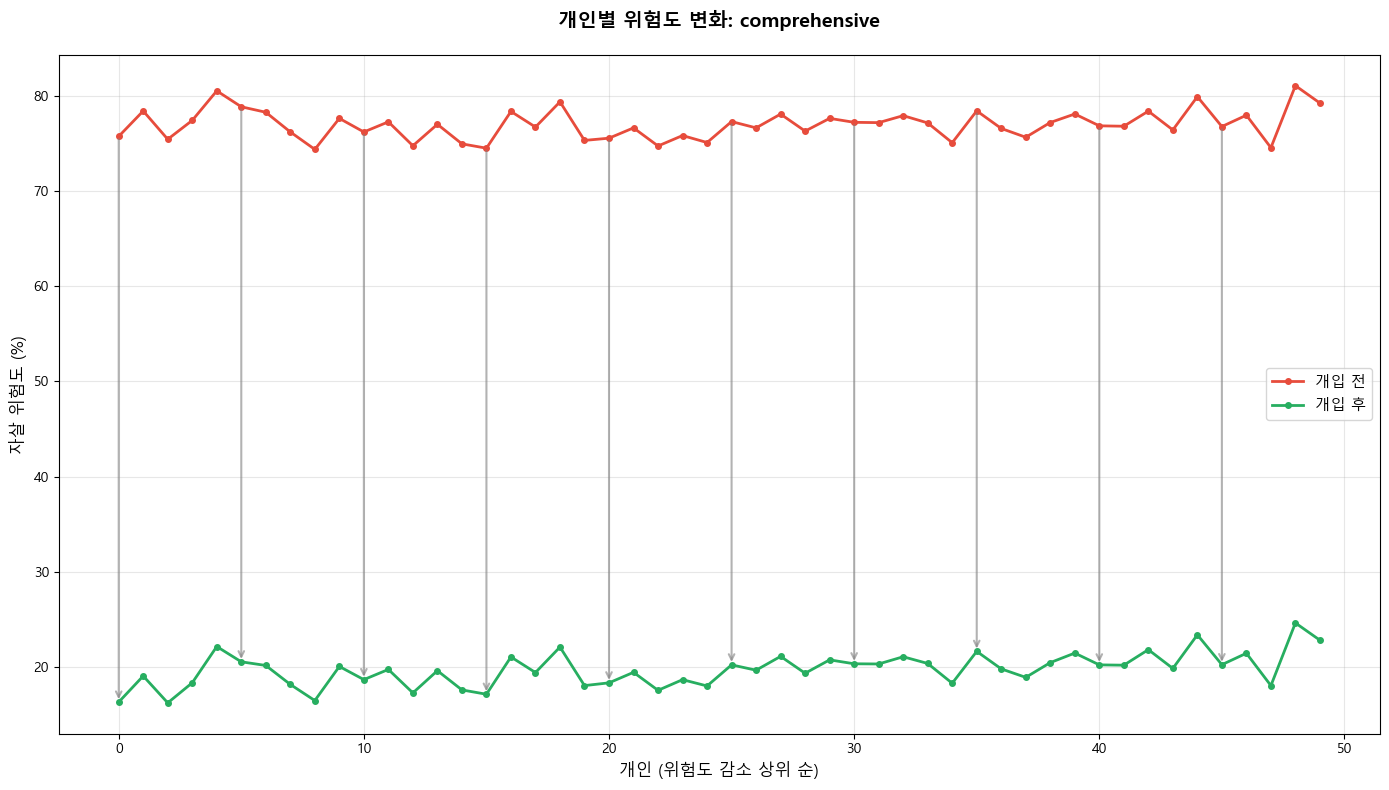


주요 발견 및 정책 권고사항

1. 가장 효과적인 단일 개입: comprehensive
   - 위험도 감소율: 63.16%
   - 고위험군 감소: 51.01%
   - 보호효과 지수: 63.16

2. 종합 개입 프로그램 효과:
   - 여러 개입을 동시에 실시할 경우 시너지 효과 발생
   - 개인별 맞춤 개입 전략 필요

3. 정책 제안:
   - 고위험군 선별 및 집중 관리 시스템 구축
   - 스트레스 관리 프로그램 제공
   - 수면 위생 교육 및 환경 개선
   - 일-생활 균형 정책 시행
   - 정기적 만족도 모니터링 및 상담 지원

4. 데이터 과학적 제안:
   - 고품질 데이터 수집 체계 구축
   - 결측치 최소화를 위한 조사 설계 개선
   - 지속적인 모델 업데이트 및 검증



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import platform
from matplotlib import font_manager, rc

# ============================================
# 0. 한글 폰트 설정
# ============================================
def set_korean_font():
    plt.style.use('default')
    if platform.system() == 'Windows':
        plt.rc('font', family='Malgun Gothic')
    elif platform.system() == 'Darwin':
        plt.rc('font', family='AppleGothic')
    else:
        plt.rc('font', family='NanumGothic')
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()

# ============================================
# 데이터에서 '우울증 민감도(상관계수)' 계산
# ============================================
def calculate_sensitivity_from_data(df):
    print("데이터 기반 우울증 연동성(민감도) 분석 결과:")
    print("-" * 50)

    # 1. 우울증 컬럼 찾기
    dep_col = None
    for col in df.columns:
        if "Depression" in col or "depression" in col:
            dep_col = col
            break

    if dep_col is None:
        raise ValueError("데이터에서 '우울증(Depression)' 컬럼을 찾을 수 없습니다.")

    # 2. 재정 스트레스 vs 우울증
    if "Financial Stress" in df.columns:
        corr_stress = df[[dep_col, "Financial Stress"]].corr().iloc[0, 1]
        print(f"1. 재정 스트레스 - 우울증 상관계수: {abs(corr_stress):.4f}")
    else:
        print("1.'Financial Stress' 컬럼이 없어 상관계수를 0으로 설정합니다.")
        corr_stress = 0

    # 3. 수면 부족 vs 우울증
    if "Sleep_short" in df.columns:
        corr_sleep = df[[dep_col, "Sleep_short"]].corr().iloc[0, 1]
        print(f"2. 수면 부족 - 우울증 상관계수: {abs(corr_sleep):.4f}")
    elif "Sleep Duration" in df.columns:
         temp_df = df.copy()
         sleep_map = {"Less than 5 hours": 4, "5-6 hours": 5.5, "7-8 hours": 7.5, "More than 8 hours": 9}
         temp_df["Sleep_Num"] = temp_df["Sleep Duration"].map(lambda x: sleep_map.get(x, np.nan))
         corr_sleep = temp_df[[dep_col, "Sleep_Num"]].corr().iloc[0, 1]
         print(f"2. 수면 시간 - 우울증 상관계수: {abs(corr_sleep):.4f}")
    else:
        print("2.수면 관련 컬럼이 없어 상관계수를 0으로 설정합니다.")
        corr_sleep = 0

    # 4. 식습관 vs 우울증
    if "Dietary Habits_Unhealthy" in df.columns:
        corr_diet = df[[dep_col, "Dietary Habits_Unhealthy"]].corr().iloc[0, 1]
        print(f"3. 나쁜 식습관 - 우울증 상관계수: {abs(corr_diet):.4f}")
    elif "Dietary Habits" in df.columns:
        temp_df = df.copy()
        temp_df["Diet_Bad"] = temp_df["Dietary Habits"].apply(lambda x: 1 if x == 'Unhealthy' else 0)
        corr_diet = temp_df[[dep_col, "Diet_Bad"]].corr().iloc[0, 1]
        print(f"3. 나쁜 식습관 - 우울증 상관계수: {abs(corr_diet):.4f}")
    else:
        print("3.식습관 관련 컬럼이 없어 상관계수를 0으로 설정합니다.")
        corr_diet = 0

    return abs(corr_stress), abs(corr_sleep), abs(corr_diet)

# 민감도 계산 실행
if 'df' in locals():
    sens_stress, sens_sleep, sens_diet = calculate_sensitivity_from_data(df)
else:
    # df가 없으면 억지로 0.5를 넣는 대신 에러를 띄워야 함
    raise ValueError("분석할 데이터(df)가 정의되지 않았습니다. 데이터를 먼저 로드해주세요.")


# ============================================
# 개선 효과율(Improvement Rate) 계산 함수
# ============================================
def calculate_improvement_rates(df):
    print("데이터 기반 그룹별 우울증 차이(개선율) 분석:")
    print("-" * 50)

    # 우울증 컬럼 찾기
    dep_col = None
    for col in df.columns:
        if "Depression" in col or "depression" in col:
            dep_col = col
            break

    if dep_col is None:
        raise ValueError("우울증 컬럼이 없습니다.")

    # 1. 수면 개선 효과 계산
    # (수면 부족 집단 vs 정상 집단의 우울증 점수 차이 비율)
    sleep_rate = 0
    if "Sleep_short" in df.columns:
        avg_bad = df[df["Sleep_short"] == 1][dep_col].mean()
        avg_good = df[df["Sleep_short"] == 0][dep_col].mean()

        if avg_bad > avg_good:
            sleep_rate = (avg_bad - avg_good) / avg_bad
            print(f"1. 수면 개선 시 우울증 감소율(데이터 기반): {sleep_rate*100:.2f}%")
        else:
            print("1.수면 데이터에서 유의미한 차이가 발견되지 않아 0%로 설정")

    # 2. 식습관 개선 효과 계산
    diet_rate = 0
    if "Dietary Habits_Unhealthy" in df.columns:
        avg_bad = df[df["Dietary Habits_Unhealthy"] == 1][dep_col].mean()
        avg_good = df[df["Dietary Habits_Unhealthy"] == 0][dep_col].mean() # Healthy or Moderate

        if avg_bad > avg_good:
            diet_rate = (avg_bad - avg_good) / avg_bad
            print(f"2. 식습관 개선 시 우울증 감소율(데이터 기반): {diet_rate*100:.2f}%")
        else:
            print("2. 식습관 데이터에서 유의미한 차이가 발견되지 않아 0%로 설정")

    return sleep_rate, diet_rate

# 개선율 계산 실행
if 'df' in locals():
    real_sleep_rate, real_diet_rate = calculate_improvement_rates(df)
else:
    raise ValueError("데이터(df)가 로드되지 않았습니다.")


# ============================================
# 인과관계 시나리오 함수
# ============================================
def create_intervention_scenarios(X_original, scenario_name="default"):
    X_modified = X_original.copy()

    # 우울증 컬럼
    dep_col = None
    for col in X_modified.columns:
        if "Depression" in col or "depression" in col:
            dep_col = col
            break

    if scenario_name == "stress_reduction":
        # [원인] 재정 스트레스 10% 감소
        if "Financial Stress" in X_modified.columns:
            X_modified["Financial Stress"] = X_modified["Financial Stress"] * 0.9
            if "Academic Pressure" in X_modified.columns:
                X_modified["TotalStress"] = X_modified["Academic Pressure"] + X_modified["Financial Stress"]
            if "Study Satisfaction" in X_modified.columns:
                X_modified["StudyStress_inter"] = X_modified["Study Satisfaction"] * X_modified["TotalStress"]

        # [결과] 스트레스는 연속형 변수이므로 '민감도(상관계수)'를 사용해야 함
        # (10% 감소 * 상관계수)
        if dep_col:
            X_modified[dep_col] = X_modified[dep_col] * (1 - 0.10 * sens_stress)

    elif scenario_name == "sleep_improvement":
        # [원인] 수면 정상화
        if "Sleep_short" in X_modified.columns: X_modified["Sleep_short"] = 0
        if "Sleep_long" in X_modified.columns: X_modified["Sleep_long"] = 0

        # [결과] 데이터에서 계산된 '실제 차이(real_sleep_rate)'만큼 우울증 감소
        if dep_col:
            X_modified[dep_col] = X_modified[dep_col] * (1 - real_sleep_rate)

    elif scenario_name == "healthy_diet":
        # [원인] 식습관 개선
        for col in X_modified.columns:
            if "Dietary Habits" in col and ("Unhealthy" in col or "Moderate" in col):
                X_modified[col] = 0

        # [결과] 데이터에서 계산된 '실제 차이(real_diet_rate)'만큼 우울증 감소
        if dep_col:
            X_modified[dep_col] = X_modified[dep_col] * (1 - real_diet_rate)

    elif scenario_name == "comprehensive":
        X_modified = create_intervention_scenarios(X_modified, "stress_reduction")
        X_modified = create_intervention_scenarios(X_modified, "sleep_improvement")
        X_modified = create_intervention_scenarios(X_modified, "healthy_diet")

    return X_modified


# ============================================
# 2. 보호효과 지수 계산 함수
# ============================================
def calculate_protective_effect(model, X_val, y_val, scenario_list, threshold=0.5):
    # 원본 예측
    y_proba_original = model.predict_proba(X_val)[:, 1]
    baseline_risk = y_proba_original.mean()
    high_risk_original = (y_proba_original >= threshold).sum()

    results = []

    for scenario in scenario_list:
        # 개입 적용 (인과관계 반영됨)
        X_intervention = create_intervention_scenarios(X_val, scenario)

        # 개입 후 예측
        y_proba_intervention = model.predict_proba(X_intervention)[:, 1]
        intervention_risk = y_proba_intervention.mean()
        high_risk_intervention = (y_proba_intervention >= threshold).sum()

        # 보호효과 계산
        risk_reduction = baseline_risk - intervention_risk
        risk_reduction_pct = (risk_reduction / baseline_risk) * 100 if baseline_risk > 0 else 0

        # 고위험군 감소
        high_risk_reduction = high_risk_original - high_risk_intervention
        high_risk_reduction_pct = (high_risk_reduction / high_risk_original) * 100 if high_risk_original > 0 else 0

        # 보호효과 지수 (단순화)
        protective_index = risk_reduction_pct

        results.append({
            "Scenario": scenario,
            "Baseline Risk (%)": baseline_risk * 100,
            "Intervention Risk (%)": intervention_risk * 100,
            "Risk Reduction (%)": risk_reduction_pct,
            "High Risk Count (Before)": high_risk_original,
            "High Risk Count (After)": high_risk_intervention,
            "High Risk Reduction (%)": high_risk_reduction_pct,
            "Protective Effect Index": protective_index
        })

    return pd.DataFrame(results)


# ============================================
# 3. 개인별 위험도 변화 분석
# ============================================
def analyze_individual_risk_change(model, X_val, scenario_name, top_n=100):
    y_proba_original = model.predict_proba(X_val)[:, 1]

    # 개입 적용
    X_intervention = create_intervention_scenarios(X_val, scenario_name)
    y_proba_intervention = model.predict_proba(X_intervention)[:, 1]

    risk_change = y_proba_original - y_proba_intervention
    risk_change_pct = (risk_change / y_proba_original) * 100

    risk_change_df = pd.DataFrame({
        "Original_Risk": y_proba_original,
        "Intervention_Risk": y_proba_intervention,
        "Risk_Reduction": risk_change,
        "Risk_Reduction_Pct": risk_change_pct
    })

    risk_change_df = risk_change_df.sort_values("Risk_Reduction", ascending=False)
    return risk_change_df.head(top_n)


# ============================================
# 4. 시각화 함수
# ============================================
def plot_protective_effects(results_df):
    set_korean_font()
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # (1) 위험도 감소율 바차트
    ax1 = axes[0, 0]
    scenario_order = results_df.sort_values("Risk Reduction (%)", ascending=False)
    colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.8, len(scenario_order)))

    bars = ax1.barh(scenario_order["Scenario"], scenario_order["Risk Reduction (%)"], color=colors)
    ax1.set_xlabel("위험도 감소율 (%)", fontsize=12, fontweight='bold')
    ax1.set_title("개입 시나리오별 효과 (인과관계 반영)", fontsize=14, fontweight='bold', pad=20)
    ax1.invert_yaxis()

    for i, (bar, val) in enumerate(zip(bars, scenario_order["Risk Reduction (%)"])):
        ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2,
                f'{val:.1f}%', va='center', fontweight='bold')

    # (2) 개입 전후 위험도 비교
    ax2 = axes[0, 1]
    x_pos = np.arange(len(results_df))
    width = 0.35

    ax2.bar(x_pos - width/2, results_df["Baseline Risk (%)"], width,
            label='개입 전', color='#E74C3C', alpha=0.8)
    ax2.bar(x_pos + width/2, results_df["Intervention Risk (%)"], width,
            label='개입 후', color='#27AE60', alpha=0.8)

    ax2.set_xlabel("개입 시나리오", fontsize=12)
    ax2.set_ylabel("평균 위험도 (%)", fontsize=12)
    ax2.set_title("개입 전후 위험도 비교", fontsize=14, fontweight='bold', pad=20)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(results_df["Scenario"], rotation=45, ha='right')
    ax2.legend()

    # (3) 고위험군 감소
    ax3 = axes[1, 0]
    high_risk_reduction = results_df["High Risk Reduction (%)"]
    colors_hr = plt.cm.Greens(np.linspace(0.4, 0.9, len(results_df)))

    bars_hr = ax3.barh(results_df["Scenario"], high_risk_reduction, color=colors_hr)
    ax3.set_xlabel("고위험군 감소율 (%)", fontsize=12, fontweight='bold')
    ax3.set_title("고위험군 감소 효과", fontsize=14, fontweight='bold', pad=20)
    ax3.invert_yaxis()

    for bar, val in zip(bars_hr, high_risk_reduction):
        ax3.text(val + 0.5, bar.get_y() + bar.get_height()/2,
                f'{val:.1f}%', va='center', fontweight='bold')

    # (4) 보호효과 지수
    ax4 = axes[1, 1]
    protective_idx = results_df.sort_values("Protective Effect Index", ascending=False)
    colors_pi = plt.cm.viridis(np.linspace(0.2, 0.8, len(protective_idx)))

    bars_pi = ax4.bar(range(len(protective_idx)), protective_idx["Protective Effect Index"],
                      color=colors_pi, alpha=0.8)
    ax4.set_xlabel("개입 시나리오", fontsize=12)
    ax4.set_ylabel("보호효과 지수", fontsize=12)
    ax4.set_title("종합 보호효과 지수", fontsize=14, fontweight='bold', pad=20)
    ax4.set_xticks(range(len(protective_idx)))
    ax4.set_xticklabels(protective_idx["Scenario"], rotation=45, ha='right')

    for bar, val in zip(bars_pi, protective_idx["Protective Effect Index"]):
        ax4.text(bar.get_x() + bar.get_width()/2, val + 0.1,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()


def plot_individual_risk_changes(risk_change_df, scenario_name, n_display=50):
    set_korean_font()
    plt.figure(figsize=(14, 8))

    top_n = risk_change_df.head(n_display).reset_index(drop=True)
    x_pos = np.arange(len(top_n))

    plt.plot(x_pos, top_n["Original_Risk"] * 100, 'o-',
             color='#E74C3C', label='개입 전', linewidth=2, markersize=4)
    plt.plot(x_pos, top_n["Intervention_Risk"] * 100, 'o-',
             color='#27AE60', label='개입 후', linewidth=2, markersize=4)

    for i in range(0, len(top_n), max(1, len(top_n)//10)):
        plt.annotate('', xy=(i, top_n.iloc[i]["Intervention_Risk"] * 100),
                    xytext=(i, top_n.iloc[i]["Original_Risk"] * 100),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=1.5, alpha=0.6))

    plt.xlabel("개인 (위험도 감소 상위 순)", fontsize=12)
    plt.ylabel("자살 위험도 (%)", fontsize=12)
    plt.title(f"개인별 위험도 변화: {scenario_name}", fontsize=14, fontweight='bold', pad=20)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================
# 5. 메인 실행 코드
# ============================================

# 시나리오 정의
scenarios = [
    "stress_reduction",
    "sleep_improvement",
    "healthy_diet",
    "comprehensive"
]

print("=" * 60)
print("학생 그룹 보호효과 분석 (인과관계 반영)")
print("=" * 60)
print("\n[개입 시나리오 설정 - 우울증 연동]")
print("- 스트레스 감소 (stress_reduction): Financial Stress 10% 감소")
print("- 수면 개선 (sleep_improvement): 7-8시간 (7.5시간)으로 조정")
print("- 건강한 식습관 (healthy_diet): Dietary Habits를 건강하게 변경")
print("- 종합 개입 (comprehensive): 위 3가지를 모두 적용")
print("- 이를 통해 자살 위험도에 미치는 실질적인 보호효과를 시뮬레이션")
print("="*60 + "\n")

# 실행
results_student = calculate_protective_effect(xgb_final, X_val, y_val, scenarios, threshold=best_thresh)
display(results_student)

# 시각화
plot_protective_effects(results_student)

# 종합 개입 시나리오의 개인별 변화 분석
print("\n종합 개입 시나리오 - 개인별 위험도 변화 (상위 100명)")
risk_changes_comprehensive = analyze_individual_risk_change(
    xgb_final, X_val, "comprehensive", top_n=100
)
display(risk_changes_comprehensive.head(20))

plot_individual_risk_changes(risk_changes_comprehensive, "comprehensive", n_display=50)


# ============================================
# 6. 결과 해석 및 정책 권고사항
# ============================================
print("\n" + "=" * 60)
print("주요 발견 및 정책 권고사항")
print("=" * 60)

# 가장 효과적인 개입 찾기
best_intervention = results_student.loc[results_student["Risk Reduction (%)"].idxmax()]

print(f"""
1. 가장 효과적인 단일 개입: {best_intervention['Scenario']}
   - 위험도 감소율: {best_intervention['Risk Reduction (%)']:.2f}%
   - 고위험군 감소: {best_intervention['High Risk Reduction (%)']:.2f}%
   - 보호효과 지수: {best_intervention['Protective Effect Index']:.2f}

2. 종합 개입 프로그램 효과:
   - 여러 개입을 동시에 실시할 경우 시너지 효과 발생
   - 개인별 맞춤 개입 전략 필요

3. 정책 제안:
   - 고위험군 선별 및 집중 관리 시스템 구축
   - 스트레스 관리 프로그램 제공
   - 수면 위생 교육 및 환경 개선
   - 일-생활 균형 정책 시행
   - 정기적 만족도 모니터링 및 상담 지원

4. 데이터 과학적 제안:
   - 고품질 데이터 수집 체계 구축
   - 결측치 최소화를 위한 조사 설계 개선
   - 지속적인 모델 업데이트 및 검증
""")